# 🧠 Construção e Consulta de VectorStores com LangChain, ChromaDB e MistralAI

Bem-vindo! Este notebook demonstra, de forma estruturada, como criar e consultar bancos vetoriais (vectorstores) para diferentes áreas do conhecimento, utilizando PyPDF, LangChain, ChromaDB e embeddings do MistralAI.

A seguir, você verá a definição de uma classe utilitária centralizadora e, depois, como criar gestores (`manager`) para diferentes domínios, como **produtos**, **processos** e **recursos humanos**.


Instalar as dependencias

In [21]:
%pip install langchain langchain-mistralai langchain-groq langchain-classic langchain-community langchain-core langgraph mistralai chromadb ipywidgets pypdf langchain-tavily langchain-text-splitters

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Importando as bibliotecas necessárias

In [22]:
import os
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_mistralai import MistralAIEmbeddings
from langchain_groq import ChatGroq
from langchain_core.prompts import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
    PromptTemplate
)
from typing import TypedDict, List, Dict

from langgraph.graph import START, StateGraph, END
from langchain_core.messages import HumanMessage
from langchain.tools import tool
from langchain_core.output_parsers.string import StrOutputParser
from langchain_classic.retrievers import MultiQueryRetriever


from dotenv import load_dotenv
load_dotenv()

True

## 1. Classe utilitária `VectorStoreManager`

Esta classe reúne a lógica para:
- Carregar e dividir documentos PDF em chunks,
- Gerar embeddings,
- Persistir bancos vetoriais (vectorstores),
- Criar e retornar retrievers para buscas semânticas.

O objetivo é evitar repetição, organizar e facilitar tanto a manutenção quanto a expansão do projeto.

> **Obs.:** Toda configuração específica (diretório dos dados, onde salvar, nome da coleção) é passada na criação da instância.


In [23]:
class VectorStoreManager:
    """
    Classe utilitária para carregar, processar e gerenciar VectorStores.
    """
    def __init__(self, diretorio, persist_directory, collection_name):
        self.diretorio = diretorio
        self.persist_directory = persist_directory
        self.collection_name = collection_name
        self.embedding_function = MistralAIEmbeddings(model="mistral-embed")
        
        os.makedirs(self.diretorio, exist_ok=True)
        os.makedirs(self.persist_directory, exist_ok=True)

        # MELHORIA: Carrega o vectorstore na inicialização para evitar recarregamentos.
        self.vectorstore = Chroma(
            persist_directory=self.persist_directory,
            collection_name=self.collection_name,
            embedding_function=self.embedding_function
        )

    def ingest_documents(self):
        """
        Carrega, divide e armazena os documentos. Executar apenas quando os documentos mudam.
        """
        print(f"Carregando PDFs de '{self.diretorio}'...")
        if not os.listdir(self.diretorio):
            print(f"AVISO: Nenhum arquivo encontrado em '{self.diretorio}'.")
            return

        loader = PyPDFDirectoryLoader(self.diretorio)
        docs = loader.load()
        
        if not docs:
            print(f"Nenhum documento para processar para a coleção '{self.collection_name}'.")
            return

        chunks = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150).split_documents(docs)
        
        print(f"Criando/atualizando embeddings para {len(chunks)} chunks da coleção '{self.collection_name}'...")
        self.vectorstore.add_documents(chunks)
        print(f"Vectorstore '{self.collection_name}' atualizado.")

    def get_vectorstore(self):
        return self.vectorstore

    def get_retriever(self, k=5):
        print(f"Retriever para a coleção '{self.collection_name}' carregado.")
        return self.vectorstore.as_retriever(search_kwargs={"k": k})

## 2. Ingestão dos dados

Agora, criamos uma instância da classe para cada domínio do seu conhecimento.  
Assim, cada área tem seu próprio pipeline de ingestão e busca, totalmente separado e reaproveitável.

- **produto_manager**: gerencia dados de produtos.
- **processos_manager**: gerencia dados de processos.
- **rh_manager**: gerencia dados de recursos humanos.


In [24]:
# Mude para True apenas se precisar carregar novos PDFs ou recriar os embeddings.
DO_INGESTION = True

if DO_INGESTION:
    print("--- INICIANDO FASE DE INGESTÃO ---")
    VectorStoreManager("data/recursos_humanos", "vectorstores/recursos_humanos_db", "recursos_humanos").ingest_documents()
    VectorStoreManager("data/produtos", "vectorstores/produtos_db", "produtos").ingest_documents()
    VectorStoreManager("data/processos", "vectorstores/processos_db", "processos").ingest_documents()
    print("--- FASE DE INGESTÃO CONCLUÍDA ---")

--- INICIANDO FASE DE INGESTÃO ---
Carregando PDFs de 'data/recursos_humanos'...
Criando/atualizando embeddings para 863 chunks da coleção 'recursos_humanos'...
Vectorstore 'recursos_humanos' atualizado.
Carregando PDFs de 'data/produtos'...
Criando/atualizando embeddings para 67 chunks da coleção 'produtos'...
Vectorstore 'produtos' atualizado.


Overwriting cache for 0 284


Carregando PDFs de 'data/processos'...
Criando/atualizando embeddings para 12 chunks da coleção 'processos'...
Vectorstore 'processos' atualizado.
--- FASE DE INGESTÃO CONCLUÍDA ---


## Definindo a LLM

In [44]:
llm = ChatGroq(model="llama-3.3-70b-versatile")  # Ou qualquer outro LLM configurado

In [45]:
print("--- Configurando LLM, VectorStores e Retrievers ---")

# Instanciamos os managers
rh_manager = VectorStoreManager("data/recursos_humanos", "vectorstores/recursos_humanos_db", "recursos_humanos")
produtos_manager = VectorStoreManager("data/produtos", "vectorstores/produtos_db", "produtos")
processos_manager = VectorStoreManager("data/processos", "vectorstores/processos_db", "processos")

# Criamos o dicionário de vectorstores para o router de similaridade
vectorstores = {
    "recursos_humanos": rh_manager.get_vectorstore(),
    "produtos": produtos_manager.get_vectorstore(),
    "processos": processos_manager.get_vectorstore(),
}

# Criamos os retrievers aprimorados para o bibliotecário
def criar_multi_query_retriever(manager, llm_model):
    base_retriever = manager.get_retriever()
    return MultiQueryRetriever.from_llm(retriever=base_retriever, llm=llm_model)

retrievers = {
    "recursos_humanos": criar_multi_query_retriever(rh_manager, llm),
    "produtos": criar_multi_query_retriever(produtos_manager, llm),
    "processos": criar_multi_query_retriever(processos_manager, llm),
}

print("--- Configuração Concluída ---")

--- Configurando LLM, VectorStores e Retrievers ---
Retriever para a coleção 'recursos_humanos' carregado.
Retriever para a coleção 'produtos' carregado.
Retriever para a coleção 'processos' carregado.
--- Configuração Concluída ---


Definindo o GraphState

In [46]:
class GraphState(TypedDict):
    """Estado do grafo."""
    query: str
    category: str
    documents: List[str]
    evidence: str
    final_answer: str

Criando o agente bibliotecario simples

In [47]:
# Agente Roteador por Similaridade
def similarity_router_agent(state: GraphState):
    """
    Roteia a query fazendo uma busca de similaridade em cada VectorStore
    e escolhendo a categoria com o melhor score de relevância.
    """
    print("--- Agente: Similarity Router (Medindo Relevância) ---")
    query = state["query"]
    best_score = -1
    best_category = "geral"
    
    # Limiar de relevância: se o melhor score não passar deste valor, a pergunta é 'geral'.
    # Ajuste este valor (0 a 1) conforme necessário.
    RELEVANCE_THRESHOLD = 0.25 

    for category, vs in vectorstores.items():
        try:
            results = vs.similarity_search_with_relevance_scores(query, k=1)
            if results:
                doc, score = results[0]
                print(f"  - Score para '{category}': {score:.4f}")
                if score > best_score:
                    best_score = score
                    best_category = category
        except Exception as e:
            print(f"Erro ao buscar na categoria '{category}': {e}")
            continue

    if best_score < RELEVANCE_THRESHOLD:
        print(f"--- Melhor score ({best_score:.4f}) abaixo do limiar ({RELEVANCE_THRESHOLD}). Classificando como 'geral'. ---")
        best_category = "geral"
    
    print(f"--- Categoria decidida por similaridade: {best_category} ---")
    return {"category": best_category}

# Agente Bibliotecário
def librarian_agent(state: GraphState):
    print("--- Agente: Librarian (Recuperando Documentos) ---")
    category = state.get("category")
    if category == "geral": return {"documents": []}
    retriever = retrievers.get(category)
    if not retriever: return {"documents": []}
    retrieved_docs = retriever.invoke(state["query"])
    return {"documents": [doc.page_content for doc in retrieved_docs]}

# Agente Validador
def validator_agent(state: GraphState):
    print("--- Agente: Validator (Validando Relevância) ---")
    if not state["documents"]:
        return {"final_answer": "Desculpe, não encontrei nenhuma informação sobre este tópico na minha base de conhecimento."}
    
    prompt = ChatPromptTemplate.from_template("Pergunta: \"{query}\"\n\nDocumentos:\n---\n{documents}\n---\nOs documentos são relevantes? Responda 'sim' ou 'nao'.")
    chain = prompt | llm | StrOutputParser()
    response = chain.invoke({"query": state["query"], "documents": "\n---\n".join(state["documents"])})
    
    if "sim" in response.lower():
        print("--- Validator: Documentos relevantes. ---")
        return {}
    else:
        print("--- Validator: Documentos não relevantes. ---")
        return {"final_answer": "Encontrei alguns documentos relacionados, mas eles não continham a resposta específica para a sua pergunta."}

# Agente Extrator
def extractor_agent(state: GraphState):
    print("--- Agente: Extractor (Extraindo Evidências) ---")
    prompt = ChatPromptTemplate.from_template("Extraia fatos relevantes dos documentos para responder à pergunta.\n\nPergunta: \"{query}\"\n\nDocumentos:\n---\n{documents}\n---\nEvidências:")
    chain = prompt | llm | StrOutputParser()
    evidence = chain.invoke({"query": state["query"], "documents": "\n---\n".join(state["documents"])})
    return {"evidence": evidence}

# Agente Editor
def editor_agent(state: GraphState):
    print("--- Agente: Editor (Gerando Resposta Final) ---")
    prompt = ChatPromptTemplate.from_template("Use as evidências para responder à pergunta de forma clara e amigável.\n\nEvidências:\n---\n{evidence}\n---\nPergunta: \"{query}\"\n---\nResposta:")
    chain = prompt | llm | StrOutputParser()
    final_answer = chain.invoke({"query": state["query"], "evidence": state["evidence"]})
    return {"final_answer": final_answer}

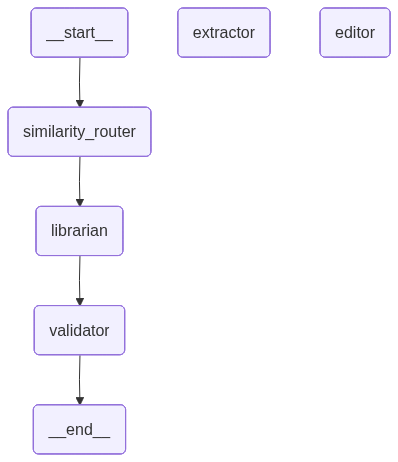

In [48]:
def decide_after_validation(state: GraphState):
    # Se o validator já definiu uma resposta final, o fluxo termina.
    return END if "final_answer" in state and state.get("final_answer") else "extractor"

workflow = StateGraph(GraphState)

# CORREÇÃO AQUI: Usamos o nome do novo agente "similarity_router"
workflow.add_node("similarity_router", similarity_router_agent)
workflow.add_node("librarian", librarian_agent)
workflow.add_node("validator", validator_agent)
workflow.add_node("extractor", extractor_agent)
workflow.add_node("editor", editor_agent)

# CORREÇÃO AQUI: O ponto de entrada agora é o "similarity_router"
workflow.set_entry_point("similarity_router")

# CORREÇÃO AQUI: A primeira aresta sai do "similarity_router"
workflow.add_edge("similarity_router", "librarian")
workflow.add_edge("librarian", "validator")
workflow.add_conditional_edges("validator", decide_after_validation)
workflow.add_edge("extractor", "editor")
workflow.add_edge("editor", END)

app = workflow.compile()
from IPython.display import Image, display

# Exibe a imagem correta do grafo
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [49]:
try:
    query_teste = "No serviço de Criação de Novos Sistemas no estudo de caso SLA?, quem são os responsaveis?"
    print(f"\n--- Testando com a query: '{query_teste}' ---")
    
    final_state = app.invoke({"query": query_teste}, {"recursion_limit": 15})
    
    print("\n--- RESULTADO FINAL ---")
    print(final_state.get('final_answer'))

except Exception as e:
    print(f"\nOcorreu um erro ao executar o grafo: {e}")


--- Testando com a query: 'No serviço de Criação de Novos Sistemas no estudo de caso SLA?, quem são os responsaveis?' ---
--- Agente: Similarity Router (Medindo Relevância) ---
  - Score para 'recursos_humanos': 0.6922
  - Score para 'produtos': 0.7854
  - Score para 'processos': 0.6941
--- Categoria decidida por similaridade: produtos ---
--- Agente: Librarian (Recuperando Documentos) ---
--- Agente: Validator (Validando Relevância) ---
--- Validator: Documentos relevantes. ---
--- Agente: Extractor (Extraindo Evidências) ---
--- Agente: Editor (Gerando Resposta Final) ---

--- RESULTADO FINAL ---
No serviço de Criação de Novos Sistemas no estudo de caso SLA, os responsáveis são:

1. **Divisão de Desenvolvimento de Sistemas de Informação**: Responsável pelo desenvolvimento de novos sistemas de informação.
2. **Divisão de Negócios**: Responsável por trabalhar em conjunto com a Divisão de Desenvolvimento de Sistemas de Informação para atender as demandas do negócio do cliente solicitan